## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

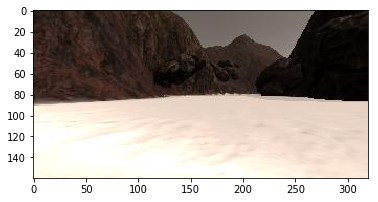

In [3]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

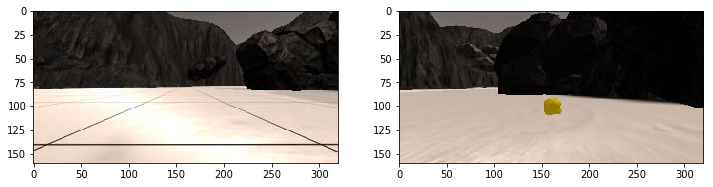

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

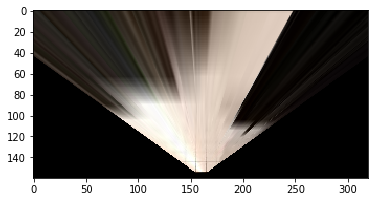

In [5]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Hints and Suggestion:** 
* For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!


* For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!).  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  

* **Beware However:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

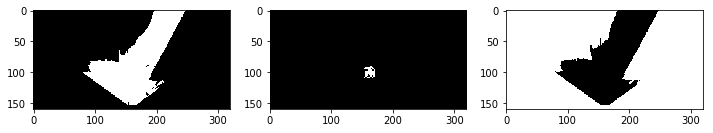

In [6]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
    & (img[:,:,1] > rgb_thresh[1]) \
    & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

def obstacle_thresh(img, rgb_thresh=(160, 160, 160)):
    obstacles = np.zeros_like(img[:,:,0])
    below_thresh = (img[:,:,0] < rgb_thresh[0]) \
                & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    obstacles[below_thresh] = 1
    return obstacles

def rock_thresh(img):
    low_yellow = np.array([20, 100, 100], dtype = "uint8")
    high_yellow = np.array([25, 255, 255], dtype = "uint8")
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV,3)
    mask_rock = cv2.inRange(img_hsv, low_yellow, high_yellow)
    return mask_rock

fig = plt.figure(figsize=(12,3))

threshed = color_thresh(warped)
plt.subplot(131)
plt.imshow(threshed, cmap='gray')

rock_threshed = rock_thresh(rock_img)
plt.subplot(132)
plt.imshow(rock_threshed, cmap='gray')

obstacle_threshed = obstacle_thresh(warped)
plt.subplot(133)
plt.imshow(obstacle_threshed, cmap='gray')

#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

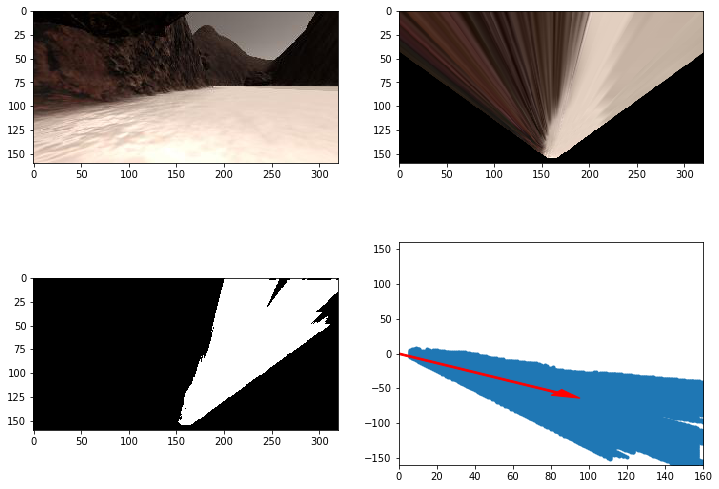

In [7]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # TODO:
    # Convert yaw to radians
    # Apply a rotation
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = xpix * np.cos(yaw_rad) - ypix * np.sin(yaw_rad)
    ypix_rotated = xpix * np.sin(yaw_rad) + ypix * np.cos(yaw_rad)
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # TODO:
    # Apply a scaling and a translation
    scale = 10
    xpix_translated = np.int_(xpos + (xpix_rot / scale))
    ypix_translated = np.int_(ypos + (ypix_rot / scale))
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [8]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [9]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    dst_size = 5 
    bottom_offset = 6
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[img.shape[1]/2 - dst_size, img.shape[0] - bottom_offset],
                  [img.shape[1]/2 + dst_size, img.shape[0] - bottom_offset],
                  [img.shape[1]/2 + dst_size, img.shape[0] - 2*dst_size - bottom_offset], 
                  [img.shape[1]/2 - dst_size, img.shape[0] - 2*dst_size - bottom_offset],
                  ])
    # 2) Apply perspective transform
    warped = perspect_transform(img, source, destination)
    
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    nav_colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
    obs_colorsel = obstacle_thresh(warped)
    rock_colorsel = rock_thresh(warped)
    
    # 4) Convert thresholded image pixel values to rover-centric coords
    nav_xpix, nav_ypix = rover_coords(nav_colorsel)
    obs_xpix, obs_ypix = rover_coords(obs_colorsel)
    rock_xpix, rock_ypix = rover_coords(rock_colorsel)
    
    # 5) Convert rover-centric pixel values to world coords
    scale = 10
    navigable_x_world, navigable_y_world = pix_to_world(nav_xpix, nav_ypix, data.xpos[data.count], 
                                data.ypos[data.count], data.yaw[data.count], 
                                data.worldmap.shape[0], scale)
    
    rock_x_world, rock_y_world = pix_to_world(rock_xpix, rock_ypix, data.xpos[data.count],
                                data.ypos[data.count], data.yaw[data.count],
                                data.worldmap.shape[0], scale)
    
    obstacle_x_world, obstacle_y_world = pix_to_world(obs_xpix, obs_ypix, data.xpos[data.count], 
                                data.ypos[data.count], data.yaw[data.count], 
                                data.worldmap.shape[0], scale)
    
    
    # 6) Update worldmap (to be displayed on right side of screen)
    #       Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
    #                       data.worldmap[rock_y_world, rock_x_world, 1] += 1
    #                       data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
    data.worldmap[rock_y_world, rock_x_world, 1] += 1
    data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    
    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [10]:
# First need to install ffmpeg dependency  
import imageio
imageio.plugins.ffmpeg.download()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

117.7572 133.3338 106.6913
[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


  3%|▎         | 9/275 [00:00<00:03, 82.94it/s]

99.66999 85.58897 46.02615
99.66999 85.58897 42.78637
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552


 10%|█         | 28/275 [00:00<00:02, 85.54it/s]

99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66999 85.58897 42.66552
99.66991 85.5889 42.66579
99.67045 85.58939 42.65512
99.67311 85.59184 42.50051
99.67796 85.59628 42.49658
99.68474 85.60247 42.38728
99.69801 85.61456 42.50288
99.71114 85.62645 42.3466


 17%|█▋        | 48/275 [00:00<00:02, 89.31it/s]

99.72617 85.64009 42.32557
99.74168 85.6541 42.34456
99.7623 85.67296 42.3979
99.78163 85.6905 42.54621
99.80393 85.71091 42.79385
99.83721 85.74142 42.81868
99.86377 85.76589 42.77251
99.89259 85.79238 42.76987
99.93379 85.83026 42.67726
99.96762 85.86127 42.63714
100.0039 85.89443 42.57428
100.0565 85.94237 42.52468
100.0984 85.98054 42.50442
100.1423 86.02047 42.51046
100.204 86.07655 42.47849
100.2528 86.12095 42.42638
100.3203 86.18372 42.60104
100.3724 86.23441 42.95958
100.4248 86.28807 43.57993


 25%|██▍       | 68/275 [00:00<00:02, 91.23it/s]

100.4952 86.3654 44.81698
100.5474 86.42741 46.07375
100.5992 86.49282 47.433
100.6511 86.56165 48.84305
100.7202 86.65863 50.77652
100.7715 86.73531 52.26539
100.8223 86.81544 53.78543
100.8893 86.92747 55.78951
100.9401 87.01521 57.08716
100.9922 87.10588 58.10785
101.0645 87.23127 59.01076
101.121 87.32846 59.38095
101.2003 87.46174 59.45411
101.2613 87.56486 59.51486
101.3208 87.67082 59.85215
101.3981 87.8151 60.80435
101.4537 87.92754 61.91304
101.5064 88.04388 63.35656
101.5708 88.20412 65.77084


 32%|███▏      | 87/275 [00:00<00:02, 91.14it/s]

101.6153 88.32789 67.67096
101.6562 88.45495 69.58232
101.7071 88.62957 71.88787
101.7438 88.76453 73.26777
101.78 88.90295 74.32909
101.8291 89.0926 75.19267
101.8673 89.23872 75.42445
101.9066 89.38844 75.46345
101.9603 89.5933 75.46242
102.0016 89.75027 75.4435
102.0437 89.90996 75.42585
102.101 90.12717 75.39845
102.1449 90.2931 75.37361
102.1885 90.46148 75.37408
102.2448 90.68527 75.34921
102.2893 90.85529 75.32796
102.3353 91.02803 75.24219
102.4004 91.26194 74.70971
102.4535 

 39%|███▊      | 106/275 [00:01<00:01, 91.36it/s]

91.4391 73.88178
102.5111 91.61623 72.63893
102.5975 91.85042 70.30107
102.6707 92.02382 68.15497
102.7508 92.19522 65.90961
102.8376 92.36436 63.64698
102.964 92.5862 60.69476
103.0653 92.75544 58.7601
103.1728 92.92551 56.84826
103.3321 93.14952 53.95889
103.46 93.3097 51.47149
103.5965 93.464 48.97135
103.79 93.66383 45.95438
103.9442 93.81035 43.73518
104.1018 93.95353 41.65498
104.3256 94.13562 38.61939
104.5021 94.26398 36.35194
104.6842 94.38795 34.11728
104.9367 94.54376 31.11737
105.1331 94.65265 28.84663


 45%|████▌     | 125/275 [00:01<00:01, 90.81it/s]

105.4036 94.7882 25.92544
105.6124 94.88326 24.01346
105.8257 94.9735 22.50324
106.1167 95.08875 21.09959
106.3388 95.17356 20.50222
106.5639 95.25844 20.27769
106.8688 95.37211 20.20613
107.1006 95.45821 20.20266
107.3349 95.54517 20.21394
107.651 95.66257 20.2414
107.8907 95.75175 20.26887
108.1324 95.842 20.30596
108.458 95.96214 20.31319
108.7024 96.05087 20.29476
108.9476 96.14009 20.27844
109.2781 96.26034 20.24175
109.5287 96.3515 20.21205
109.7817 96.44343 20.18246
110.037 96.53608 20.15311


 53%|█████▎    | 145/275 [00:01<00:01, 90.44it/s]

110.3809 96.66068 20.11385
110.6414 96.75487 20.08391
110.9919 96.88136 20.04218
111.2566 96.97666 20.01408
111.523 97.07241 19.97973
111.8818 97.20103 19.93494
112.1534 97.29821 19.90165
112.4271 97.396 19.86829
112.7953 97.52721 19.82319
113.0733 97.62608 19.78699
113.3534 97.72549 19.75085
113.7302 97.85891 19.70393
114.0141 97.9592 19.66882
114.2977 98.05927 19.65091
114.5803 98.16029 19.86094
114.9555 98.30025 20.70059
115.2342 98.40908 21.86152
115.598 98.56515 23.84052


 60%|██████    | 165/275 [00:01<00:01, 91.12it/s]

115.866 98.68844 25.84151
116.1281 98.82074 27.91245
116.4713 99.00774 30.25878
116.7303 99.15353 31.47953
116.9924 99.30441 32.27011
117.3378 99.51661 33.06346
117.5936 99.68007 33.32758
117.8483 99.84537 33.43478
118.1026 100.0116 33.48189
118.4411 100.2336 33.48425
118.6948 100.4003 33.44147
119.034 100.6228 33.39663
119.2876 100.7902 33.41882
119.5374 100.958 33.70485
119.7836 101.1259 34.30563
120.1092 101.3574 35.69389
120.3483 101.5358 37.19131
120.6563 101.7811 39.8752
120.8784 101.973 41.99055


 64%|██████▎   | 175/275 [00:01<00:01, 90.02it/s]

121.0927 102.1712 44.14117
121.306 102.3763 45.95802
121.5871 102.6613 48.17831
121.7941 102.8837 49.6844
121.9925 103.1136 51.47852
122.2437 103.4249 53.40541
122.424 103.6644 54.20872
122.6603 103.9871 54.59333
122.8362 104.2307 54.6774
123.0116 104.475 54.70125
123.1868 104.7207 54.70881
123.4207 105.0494 54.70484
123.5965 105.2966 54.70491
123.7723 105.5437 54.68962
124.0069 105.8742 54.72599
124.1813 106.1234 55.02958


 67%|██████▋   | 185/275 [00:02<00:00, 91.40it/s]

124.4097 106.457 55.95851
124.5742 106.7094 57.2341
124.7325 106.964 58.79436


 71%|███████   | 195/275 [00:02<00:00, 90.36it/s]

124.8812 107.2223 60.85209
125.0649 107.5708 63.71728
125.191 107.8355 65.922
125.3075 108.1036 68.07704
125.4566 108.4709 70.51936
125.5612 108.7535 72.25469
125.6581 109.0405 74.13517
125.7688 109.4241 77.03481
125.8323 109.7162 79.33396
125.8847 110.0118 81.42004
125.9421 110.4066 84.06995
125.9747 110.7047 86.11799
125.9963 111.0033 88.09606
126.0085 111.4032 90.59647
126.0049 111.703 92.18704
125.994 112.0033 93.40936
125.972

 75%|███████▍  | 205/275 [00:02<00:00, 90.62it/s]

 112.4032 94.48029
125.9509 112.7034 94.86752
125.9274

 78%|███████▊  | 215/275 [00:02<00:00, 89.56it/s]

 113.0039 95.01511
125.8938 113.4056 95.08121
125.8678 113.7073 95.09045
125.8417 114.0098 95.09473
125.8069 114.413 95.08292
125.7807 114.7156 95.06079
125.7536 115.0187 95.16846
125.7134 115.4223 95.80148
125.6798 115.7229 96.71628
125.6247 116.1201 98.52539
125.5746 116.4148 100.429
125.5147 116.7047 102.4129
125.4468 116.9912 104.567
125.341 117.3663 107.5143
125.252 117.6454 109.4957
125.1248 118.0227 111.4766
125.0218 118.308 112.5845


 81%|████████▏ | 224/275 [00:02<00:00, 88.97it/s]

124.9101 118.5921 113.7083
124.791 118.8712 114.5901


 85%|████████▍ | 233/275 [00:02<00:00, 88.45it/s]

124.6262 119.2397 115.0765
124.4996 119.515 115.1923
124.3719 119.7901 115.2336
124.2013 120.1562 115.178
124.0732 120.4315 115.1701
123.9456 120.7064 115.0836
123.7753 121.073 115.0023
123.6466 121.3465 115.013
123.5205 121.616 114.9783
123.3525 121.9778 115.003
123.2249 122.2494 115.3029
123.0941 122.5198 115.8837
122.9127 122.8768 116.9544
122.776 123.1399 118.1294
122.6361 123.4037 118.8654
122.4467 123.7537 119.1853


 88%|████████▊ | 243/275 [00:02<00:00, 89.27it/s]

122.3031 124.0158 119.2408
122.1585 124.2777 119.2498
121.9653 124.6262 119.2363


 92%|█████████▏| 252/275 [00:02<00:00, 87.57it/s]

121.8207 124.887 119.2194
121.6765 125.1469 119.2042
121.485 125.4914 119.1922
121.342 125.7488 119.1816
121.1994 126.0058 119.163
121.0098 126.3469 119.1457
120.868 126.6018 119.1359
120.7264 126.8557 119.1333
120.5386 127.1938 119.1125
120.3979 127.4461 119.1093
120.2092 127.7817 119.1422
120.069 128.0325 119.1499
119.9282 128.2828 119.1736
119.7415 128.6157 119.1972
119.6024 128.8643 119.2031
119.464 129.1121 119.205
119.3253 129.3592 119.2035


 98%|█████████▊| 270/275 [00:03<00:00, 85.46it/s]

119.1448 129.6888 118.7932
119.014 129.9368 118.073
118.8876 130.1863 117.0032
118.7296 130.5226 114.9889
118.6175 130.7785 113.2869
118.5108 131.0382 111.6072
118.3782 131.3808 109.5371
118.2847 131.6338 108.1559
118.201 131.8869 107.257
118.0929 132.2276 106.7651
118.0132 132.4843 106.7066
117.9355 132.7403 106.6948
117.8332 133.0802 106.6925


100%|██████████| 275/275 [00:03<00:00, 89.27it/s]

117.7572 133.3338 106.6913


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

CPU times: user 2.97 s, sys: 283 ms, total: 3.26 s
Wall time: 3.23 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [11]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [12]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))